Source: https://github.com/ADA-SITE-JML/gesture_face_features/

##

Notes: PATH

AVGPOOL FOR VGG IS FALSE
FC FOR PREDICTIONS NO LONGER IS IN FEATS RETURN NODES
CHECK PATHS

In [1]:
# !git clone https://github.com/ADA-SITE-JML/gesture_face_features/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import os

# modify the project path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, 'code', 'main'))

DATA_PATH = os.path.join(PATH, 'samples', 'sign')
FEAT_PATH = os.path.join(PATH, 'out', 'feats')

# modify paths accordingly for saving to/loading from
EMB_PATH  = os.path.join(PATH, 'out', 'embeddings')

%load_ext autoreload
%autoreload 2

In [4]:
# installing libraries for UMAP and MTE

!pip install -q umap-learn # https://umap-learn.readthedocs.io/en/latest/
!git clone -q https://github.com/thuml/Transfer-Learning-Library/

fatal: destination path 'Transfer-Learning-Library' already exists and is not an empty directory.


In [5]:
# data setup

from data_folder import SignImageFolder
from torch.utils.data import DataLoader
from torch import cuda

dataset = SignImageFolder(DATA_PATH)
dataloader = DataLoader(dataset, batch_size=16,
                        num_workers=os.cpu_count(),
                        pin_memory=cuda.is_available())
print(f"Count: {len(dataset)}")

Count: 206


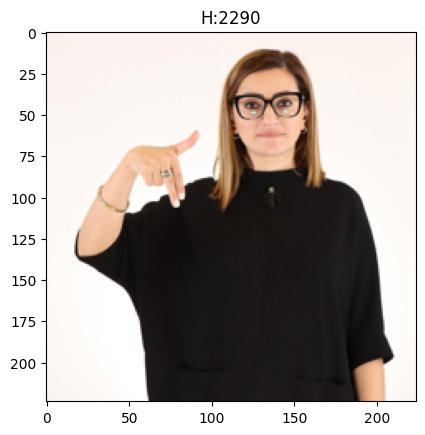

In [6]:
dataset.plot(42)

In [7]:
# extracting feature maps for checkpoint layers
# return nodes are defined in config.py

# VGG19 PyTorch implementation includes avgpool

from config import MODEL_ZOO, MIN_PARAM_GRID, FULL_PARAM_GRID
from model_loader import ModelLoader
from feature import extract_features

In [8]:
MODEL_ZOO

{'vgg19': {'input_dim': (224, 224),
  'return_nodes': ['features.34', 'features.35', 'avgpool', 'classifier.6']},
 'resnet50': {'input_dim': (224, 224),
  'return_nodes': ['layer4.2.relu_2', 'avgpool', 'fc']},
 'inception_v3': {'input_dim': (299, 299),
  'return_nodes': ['Mixed_7c.branch_pool.conv', 'avgpool', 'fc']},
 'efficientnet_b0': {'input_dim': (224, 224),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']},
 'efficientnet_b1': {'input_dim': (240, 240),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']},
 'efficientnet_b6': {'input_dim': (528, 528),
  'return_nodes': ['features.8', 'avgpool', 'classifier.1']}}

In [17]:
feats = {}
for model_name in MODEL_ZOO:
  modelloader = ModelLoader(model_name)
  feats[model_name] = extract_features(dataloader, modelloader, FEAT_PATH)

Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/vgg19_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/resnet50_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/inception_v3_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b0_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b1_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/out/feats/efficientnet_b6_feats.pt.


In [18]:
# getting dummy predictions
from utils import decode_imagenet, predict, delete_keys

for model_name in MODEL_ZOO:
  preds, idx, _ = predict(model_name, feats)
  label_counts, _ = decode_imagenet(idx)
  print(f'Predictions of {model_name}: {label_counts}')

torch.Size([206, 1000])
Predictions of vgg19: {'jersey': 67, 'sweatshirt': 62, 'suit': 34, 'military_uniform': 33, 'cardigan': 4, 'wig': 4, 'abaya': 2}
torch.Size([206, 1000])
Predictions of resnet50: {'suit': 113, 'wool': 37, 'jersey': 28, 'wig': 25, 'sunglasses': 2, 'safety_pin': 1}
torch.Size([206, 1000])
Predictions of inception_v3: {'jersey': 50, 'wool': 45, 'sweatshirt': 35, 'suit': 27, 'wig': 23, 'Band_Aid': 10, 'velvet': 5, 'sunglasses': 4, 'tench': 3, 'maillot': 2, 'abaya': 1, 'bow_tie': 1}
torch.Size([206, 1000])
Predictions of efficientnet_b0: {'sweatshirt': 62, 'suit': 34, 'military_uniform': 34, 'abaya': 32, 'wig': 30, 'jersey': 11, 'wool': 3}
torch.Size([206, 1000])
Predictions of efficientnet_b1: {'jersey': 40, 'sweatshirt': 37, 'wool': 37, 'suit': 34, 'abaya': 29, 'necklace': 23, 'perfume': 3, 'sunglasses': 2, 'wig': 1}
torch.Size([206, 1000])
Predictions of efficientnet_b6: {'sweatshirt': 66, 'jersey': 38, 'wool': 37, 'suit': 28, 'cardigan': 18, 'wig': 18, 'abaya': 1}


In [19]:
### Data Partitioning (3.1.1) ###

from participant import filter_participants, filter_targets

# Set partition to False for experimenting with all features on a single partition
partition = True

if partition:
  parts = filter_participants(feats, dataset)
  targets = filter_targets(dataset)

In [31]:
### Initial MTE Ranking (Section 3.3) ###

%cd Transfer-Learning-Library

from mte import get_mte_scores

# for i in range(len(parts)):
#   print(f'-----Participant {i}-----')
#   get_mte_scores(parts[i], targets[i])

[Errno 2] No such file or directory: 'Transfer-Learning-Library'
/content/Transfer-Learning-Library
-----Participant 0-----
Calculating scores for vgg19...
Calculating scores for resnet50...
Calculating scores for inception_v3...
Calculating scores for efficientnet_b0...
Calculating scores for efficientnet_b1...
Calculating scores for efficientnet_b6...

=== Ranked Models by LEEP ===
Rank  Model                Score          
---------------------------------------------
1     efficientnet_b6      -1.918715
2     efficientnet_b0      -1.927447
3     vgg19                -1.931031
4     efficientnet_b1      -1.931654
5     inception_v3         -1.935066
6     resnet50             -1.941351


=== Ranked Models by LogME ===
Rank  Model                Score          
---------------------------------------------
1     efficientnet_b6      -0.359512
2     efficientnet_b0      -0.383698
3     resnet50             -0.397275
4     inception_v3         -0.412222
5     efficientnet_b1      -0.41

In [40]:
for model in MODEL_ZOO:
  print(parts[0][model].keys())

dict_keys(['features.35', 'avgpool'])
dict_keys(['layer4.2.relu_2', 'avgpool'])
dict_keys(['Mixed_7c.branch_pool.conv', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])


In [62]:
N = len(parts)

for i in range(N):
  for model_name in parts[i]:
    delete_keys(parts[i][model_name], key_list=[
         'classifier.1', 'classifier.6','fc',
         'features.34', 'features.36', 'layer4.2.conv3'
        ])

In [63]:
for model in MODEL_ZOO:
  print(parts[0][model].keys())

dict_keys(['features.35', 'avgpool'])
dict_keys(['layer4.2.relu_2', 'avgpool'])
dict_keys(['Mixed_7c.branch_pool.conv', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])
dict_keys(['features.8', 'avgpool'])


In [44]:
### Main Experiments ###

from engines.reducer import Reducer, ReducerEngine
from engines.embedding import Embedding, EmbeddingEngine
from engines.cluster import Cluster, ClusterEngine
from engines.engine import Engine

RANDOM_STATE = 42

In [46]:
### Dimensionality Reduction (Section ) ###

r = Reducer(parts[0], targets[0], 'resnet50', 'avgpool', 'umap', random_state=RANDOM_STATE)
r.get_embedding(params={'n_neighbors': 10,'min_dist': 0.3,'metric': 'euclidean'})
r.embedding

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 7.2575874, 17.821451 ],
       [ 6.736015 , 18.857914 ],
       [ 6.9413095, 18.321154 ],
       [ 8.527893 , 14.216325 ],
       [ 8.209682 , 13.620561 ],
       [ 8.20389  , 14.160456 ],
       [ 6.6109304, 16.646685 ],
       [ 8.1699295, 14.875522 ],
       [ 7.5215507, 14.600852 ],
       [ 5.562185 , 16.78135  ],
       [ 8.116776 , 15.609563 ],
       [ 5.989176 , 16.48315  ],
       [ 7.69527  , 15.332857 ],
       [ 6.0152087, 16.064627 ],
       [ 8.619811 , 14.762594 ],
       [ 5.647985 , 17.285141 ],
       [ 5.9963565, 20.099365 ],
       [ 7.5187416, 15.942788 ],
       [ 7.500817 , 16.919357 ],
       [ 6.7045217, 15.039201 ],
       [ 5.479563 , 19.54473  ],
       [ 6.5565295, 19.804998 ],
       [ 6.70312  , 14.101069 ],
       [ 6.4379063, 19.292448 ],
       [ 7.2197127, 13.821501 ],
       [ 6.4496355, 14.326124 ],
       [ 6.136316 , 17.566181 ],
       [ 6.350311 , 18.43432  ],
       [ 7.7581024, 14.335703 ],
       [ 7.1724787, 15.512666 ],
       [ 6

In [47]:
e = Embedding(r, 'kmeans', n_clusters=7, random_state=RANDOM_STATE)
e.get_clusters()
e.cluster

array([3, 3, 3, 2, 2, 2, 0, 5, 5, 0, 6, 0, 6, 0, 2, 0, 1, 6, 6, 5, 1, 1,
       4, 1, 4, 4, 3, 3, 5, 6, 3, 1, 1, 4, 1, 1, 3], dtype=int32)

In [48]:
c = Cluster(e)
c

-------resnet50 avgpool-------

Cluster 3: ['A', 'A', 'A', 'P', 'P', 'P', 'R']
Cluster 2: ['A', 'A', 'A', 'L']
Cluster 0: ['H', 'H', 'L', 'L', 'L']
Cluster 5: ['H', 'H', 'N', 'P']
Cluster 6: ['H', 'L', 'N', 'N', 'P']
Cluster 1: ['N', 'N', 'O', 'O', 'R', 'R', 'R', 'R']
Cluster 4: ['O', 'O', 'O', 'R']

Purity: 0.54
Custom Weighted Score: 0.55

In [49]:
MIN_PARAM_GRID
# FULL_PARAM_GRID

{'umap': {'n_neighbors': [5, 15, 30],
  'min_dist': [0.01, 0.1, 0.3],
  'metric': ['euclidean']},
 'tsne': {'perplexity': [10, 15, 25],
  'learning_rate': [100],
  'metric': ['euclidean']},
 'pca': {'whiten': [False], 'svd_solver': ['full']}}

In [56]:
# don't use random state for parallelism

res = [{method: None for method in MIN_PARAM_GRID} for _ in range(N)]

for i in range(6):
  print(f'\n------- Participant {i}---------')
  emb_path = os.path.join(EMB_PATH, str(i))

  for method in MIN_PARAM_GRID:
    re = ReducerEngine(
      parts[i],
      targets[i],
      method=method,
      param_grids=MIN_PARAM_GRID,
      n_components=2,
      random_state=RANDOM_STATE,
      emb_path=emb_path,
    )
    re.get_all_embeddings(from_disk=True)
    res[i][method] = re


------- Participant 0---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_solver': ['full']}.

------- Participant 1---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_solver': ['full']}.

------- Participant 2---------
Getting umap embeddings for grid {'n_neighbors': [5, 15, 30], 'min_dist': [0.01, 0.1, 0.3], 'metric': ['euclidean']}.
Getting tsne embeddings for grid {'perplexity': [10, 15, 25], 'learning_rate': [100], 'metric': ['euclidean']}.
Getting pca embeddings for grid {'whiten': [False], 'svd_sol

In [ ]:
def get_nleep_score(self, cluster=None, factor=1, random_state=None):
  cluster = cluster or self.ce.best_cluster
  n_components = cluster.embedding.n_clusters * factor
  embedding = cluster.embedding.reducer.embedding
  random_state = random_state or self.random_state
  targets = cluster.embedding.reducer.targets

  gmm = GaussianMixture(n_components=n_components, random_state=random_state)
  gmm.fit(embedding)
  gmm_predictions = gmm.predict_proba(embedding)
  # cluster.nleep_score = LEEP(gmm_predictions, targets)
  cluster.nleep_score = log_expected_empirical_prediction(gmm_predictions, targets)
  return cluster.nleep_score

In [93]:
from mte import get_nleep_score

# First, create empty containers
ees = [{} for _ in range(N)]
ces = [{} for _ in range(N)]

for i, re in enumerate(res):
  print(f'-----Participant {i}-----')
  for method in MIN_PARAM_GRID:
    print(method)
    for model in ['kmeans', 'gmm']:
      ee = EmbeddingEngine(re[method], model, n_clusters=7, random_state=RANDOM_STATE)
      ee.get_all_clusters()
      ce = ClusterEngine(ee)
      ce.score_all_clusters()
      for cluster in ce.scored_clusters:
        get_nleep_score(cluster, random_state=RANDOM_STATE)
      ees[i][(method, model)] = ee
      ces[i][(method, model)] = ce

Streaming output truncated to the last 5000 lines.
Cluster 0: ['H', 'H', 'L', 'L', 'L']
Cluster 4: ['N', 'N', 'N', 'O', 'R']
Cluster 6: ['N', 'N', 'P', 'P', 'P', 'R']
Cluster 1: ['O', 'R']
Cluster 3: ['O', 'O', 'P']

Purity: 0.66
Custom Weighted Score: 0.66

Generating NLEEP for the best cluster
-------inception_v3 avgpool-------

Cluster 2: ['A', 'A', 'A', 'L']
Cluster 5: ['A', 'H']
Cluster 0: ['H', 'H', 'H', 'H', 'L', 'L', 'L']
Cluster 6: ['N', 'N', 'N', 'R']
Cluster 3: ['N', 'O', 'O', 'O', 'R']
Cluster 1: ['N', 'O', 'P', 'R']
Cluster 4: ['P', 'P', 'P']

Purity: 0.62
Custom Weighted Score: 0.61

Generating NLEEP for the best cluster
-------efficientnet_b0 features.8-------

Cluster 0: ['A', 'H', 'H', 'H', 'L']
Cluster 5: ['A', 'A', 'A', 'L', 'L']
Cluster 2: ['H', 'H', 'L']
Cluster 6: ['N', 'N', 'O', 'R']
Cluster 4: ['N', 'N', 'P', 'P', 'R']
Cluster 1: ['N', 'O', 'O', 'P', 'P', 'R']
Cluster 3: ['O']

Purity: 0.52
Custom Weighted Score: 0.44

Generating NLEEP for the best cluster
-----

In [112]:
from rank import rank_clusters, plot_ranking

part   = 5
method = ['pca','umap','tsne'][1]
model  = ['kmeans','gmm'][1]
metric = ['custom','nleep'][0]

ce = ces[part][(method, model)]
scored_clusters = ce.scored_clusters
ranked_clusters = rank_clusters(scored_clusters, metric=metric)
df = plot_ranking(scored_clusters, ranked_clusters,  metric=metric)
df

,model,layer,params,custom,mean
0,efficientnet_b0,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.94,0.79
1,efficientnet_b6,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.93,0.79
2,efficientnet_b1,avgpool,"{'metric': 'euclidean', 'min_dist': 0.1, 'n_ne...",0.91,0.70
3,resnet50,avgpool,"{'metric': 'euclidean', 'min_dist': 0.3, 'n_ne...",0.89,0.74
4,inception_v3,avgpool,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.84,0.75
5,vgg19,features.35,"{'metric': 'euclidean', 'min_dist': 0.01, 'n_n...",0.77,0.68


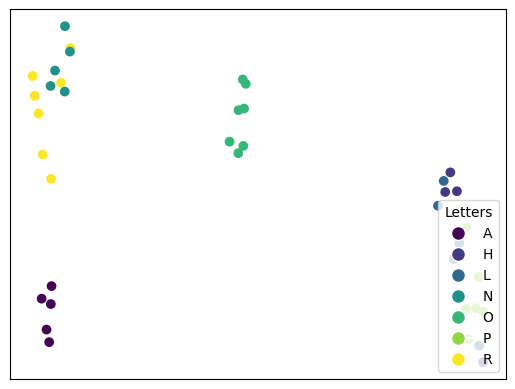

In [113]:
ces[5][('umap','gmm')].best_cluster.embedding.reducer.plot(dataset.idx_to_class)

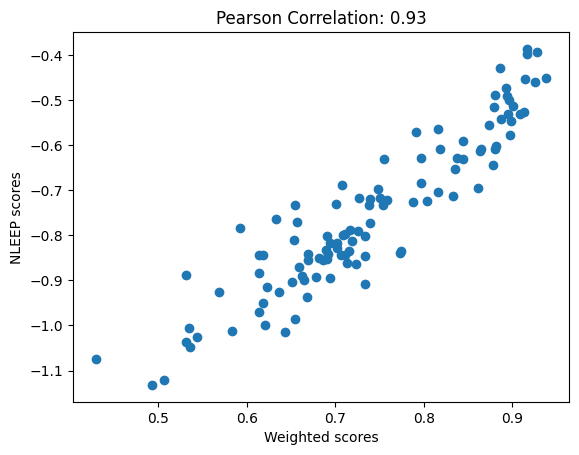

In [114]:
import numpy as np
import matplotlib.pyplot as plt

nleep_scores = [cluster.nleep_score for cluster in ce.scored_clusters]
scores = [cluster.score for cluster in ce.scored_clusters]
corr = np.corrcoef(scores, nleep_scores)[0, 1]

plt.scatter(scores, nleep_scores)
plt.xlabel('Weighted scores')
plt.ylabel('NLEEP scores')
plt.title(f'Pearson Correlation: {corr:.2}');

In [117]:
import pandas as pd

index = MODEL_ZOO
columns = list(range(part + 1)) + ['Total']
counts_df = pd.DataFrame(0, index=index, columns=columns)

for i in range(part + 1):
  ce = ces[i][(method, model)]
  scored_clusters = ce.scored_clusters
  ranked_clusters = rank_clusters(scored_clusters,  metric=metric)
  for cluster in ranked_clusters[:1]:  # top_n = 1
      model_name = cluster.embedding.reducer.model_name
      if model_name in counts_df.index:
          counts_df.at[model_name, i] += 1

counts_df['Total'] = counts_df[list(range(part + 1))].sum(axis=1)
counts_df = counts_df.sort_values(by='Total', ascending=False)

counts_df

,0,1,2,3,4,5,Total
efficientnet_b0,0,0,0,1,0,1,2
resnet50,1,0,0,0,0,0,1
efficientnet_b1,0,0,0,0,1,0,1
inception_v3,0,1,0,0,0,0,1
efficientnet_b6,0,0,1,0,0,0,1
vgg19,0,0,0,0,0,0,0
